In [ ]:
# PROJECT NAME - Local Food Wastage Management System.

In [ ]:
# STEP 1 - Install & Import Libraries

!pip install pandas sqlalchemy matplotlib seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from datetime import datetime
# Pandas display options for better viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [ ]:
# STEP 2 - Upload & Load Datasets

# Function to upload and read a CSV file
def upload_and_read_csv(prompt_text):
    print(prompt_text)
    uploaded_file = files.upload()
    file_name = list(uploaded_file.keys())[0]  # Get the first uploaded filename
    return pd.read_csv(file_name)
# Upload and load datasets
providers_df = upload_and_read_csv("📂 Upload Providers.csv")
receivers_df = upload_and_read_csv("📂 Upload Receivers.csv")
food_listings_df = upload_and_read_csv("📂 Upload Food Listings.csv")
claims_df = upload_and_read_csv("📂 Upload Claims.csv")
print("✅ All datasets uploaded and loaded successfully!")

📂 Upload Providers.csv


Saving Providers.csv to Providers.csv
📂 Upload Receivers.csv


Saving Receivers.csv to Receivers.csv
📂 Upload Food Listings.csv


Saving Food Listings.csv to Food Listings.csv
📂 Upload Claims.csv


Saving Claims.csv to Claims.csv
✅ All datasets uploaded and loaded successfully!


In [ ]:
# STEP 3 - Data Preparation

# Convert date columns to datetime
date_columns = {
    "food_listings": ("Expiry_Date", food_listings_df),
    "claims": ("Timestamp", claims_df)
}
for name, (col, df) in date_columns.items():
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")
# Function to check and display duplicates
def check_duplicates(df, name):
    dup_count = df.duplicated().sum()
    print(f"🔍 Duplicate records in {name}: {dup_count}")
# Check duplicates for all datasets
check_duplicates(providers_df, "Providers")
check_duplicates(receivers_df, "Receivers")
check_duplicates(food_listings_df, "Food Listings")
check_duplicates(claims_df, "Claims")
print("✅ Data cleaning and duplicate check completed!")

🔍 Duplicate records in Providers: 0
🔍 Duplicate records in Receivers: 0
🔍 Duplicate records in Food Listings: 0
🔍 Duplicate records in Claims: 0
✅ Data cleaning and duplicate check completed!


In [ ]:
# STEP 4 - Database Creation

from sqlalchemy import create_engine
# Create SQLite engine
engine = create_engine("sqlite:///Food Wastage.db", echo=False)
# Dictionary of DataFrames and table names
tables = {
    "providers": providers_df,
    "receivers": receivers_df,
    "food_listings": food_listings_df,
    "claims": claims_df
}
# Store data into SQL tables
for table_name, df in tables.items():
    try:
        df.to_sql(table_name, con=engine, if_exists="replace", index=False)
        print(f"✅ '{table_name}' table uploaded successfully with {len(df)} records.")
    except Exception as e:
        print(f"❌ Failed to upload '{table_name}' table: {e}")
print("\n📦 All available datasets have been stored in the database: 'food_wastage.db'")

✅ 'providers' table uploaded successfully with 1000 records.
✅ 'receivers' table uploaded successfully with 1000 records.
✅ 'food_listings' table uploaded successfully with 1000 records.
✅ 'claims' table uploaded successfully with 1000 records.

📦 All available datasets have been stored in the database: 'food_wastage.db'


In [ ]:
# STEP 5 - CRUD Operations

from sqlalchemy import text
# CREATE
def create_food_listing(food_id, name, qty, expiry, provider_id, provider_type, location, food_type, meal_type):
    """Add a new food listing record."""
    with engine.begin() as conn:
        conn.execute(text("""
            INSERT INTO food_listings (Food_ID, Food_Name, Quantity, Expiry_Date, Provider_ID, Provider_Type, Location, Food_Type, Meal_Type)
            VALUES (:fid, :fname, :qty, :expiry, :pid, :ptype, :loc, :ftype, :mtype)
        """), {
            "fid": food_id, "fname": name, "qty": qty, "expiry": expiry,
            "pid": provider_id, "ptype": provider_type, "loc": location,
            "ftype": food_type, "mtype": meal_type
        })
    print(f"✅ Food listing '{name}' added.")
# READ
def read_food_listings(city=None):
    """Retrieve food listings, optionally filtered by city."""
    with engine.connect() as conn:
        if city:
            query = text("SELECT * FROM food_listings WHERE Location = :city")
            df = pd.read_sql(query, conn, params={"city": city})
        else:
            df = pd.read_sql("SELECT * FROM food_listings", conn)
    return df
# UPDATE
def update_food_quantity(food_id, new_qty):
    """Update the quantity of a specific food listing."""
    with engine.begin() as conn:
        conn.execute(text("""
            UPDATE food_listings
            SET Quantity = :qty
            WHERE Food_ID = :fid
        """), {"qty": new_qty, "fid": food_id})
    print(f"✅ Quantity updated for Food_ID {food_id} to {new_qty}.")
# DELETE
def delete_food_listing(food_id):
    """Delete a food listing record by Food_ID."""
    with engine.begin() as conn:
        conn.execute(text("""
            DELETE FROM food_listings
            WHERE Food_ID = :fid
        """), {"fid": food_id})
    print(f"✅ Food listing with ID {food_id} deleted.")

In [ ]:
# STEP 6 - CRUD Demo

# CREATE example
create_food_listing(
    2001, "Rice", 50, "2025-03-30",
    1, "Restaurant", "New Jessica",
    "Vegetarian", "Lunch"
)
# READ example
print("\n📌 Food Listings in New Jessica:")
df_nj = read_food_listings("New Jessica")
print(df_nj.head())
# UPDATE example
update_food_quantity(2001, 60)
# READ after update
print("\n📌 Food Listings in New Jessica after update:")
df_nj_updated = read_food_listings("New Jessica")
print(df_nj_updated.head())
# DELETE example
delete_food_listing(2001)
# Verify deletion
print("\n📌 Food Listings in New Jessica after deletion:")
df_nj_deleted = read_food_listings("New Jessica")
print(df_nj_deleted.head())

✅ Food listing 'Rice' added.

📌 Food Listings in New Jessica:
   Food_ID Food_Name  Quantity                 Expiry_Date  Provider_ID Provider_Type     Location   Food_Type  Meal_Type
0       23     Salad        43  2025-03-26 00:00:00.000000            1   Supermarket  New Jessica       Vegan     Dinner
1       36      Rice        35  2025-03-20 00:00:00.000000            1   Supermarket  New Jessica       Vegan  Breakfast
2     2001      Rice        50                  2025-03-30            1    Restaurant  New Jessica  Vegetarian      Lunch
✅ Quantity updated for Food_ID 2001 to 60.

📌 Food Listings in New Jessica after update:
   Food_ID Food_Name  Quantity                 Expiry_Date  Provider_ID Provider_Type     Location   Food_Type  Meal_Type
0       23     Salad        43  2025-03-26 00:00:00.000000            1   Supermarket  New Jessica       Vegan     Dinner
1       36      Rice        35  2025-03-20 00:00:00.000000            1   Supermarket  New Jessica       Vegan  Break

In [ ]:
# STEP 7 - Basic Analysis

queries = {
    "Total Providers by City": """
        SELECT City, COUNT(*) AS Provider_Count
        FROM providers
        GROUP BY City
        ORDER BY Provider_Count DESC
    """,
    "Most Common Food Types": """
        SELECT Food_Type, COUNT(*) AS Count
        FROM food_listings
        GROUP BY Food_Type
        ORDER BY Count DESC
    """,
    "Top 5 Cities by Food Listings": """
        SELECT Location, COUNT(*) AS Listing_Count
        FROM food_listings
        GROUP BY Location
        ORDER BY Listing_Count DESC
        LIMIT 5
    """,
    "Claim Status Distribution": """
        SELECT Status, COUNT(*) AS Count
        FROM claims
        GROUP BY Status
    """
}
with engine.connect() as conn:
    for title, sql in queries.items():
        print(f"\n📊 {title}")
        df = pd.read_sql(text(sql), conn)
        print(df.to_string(index=False))


📊 Total Providers by City
                    City  Provider_Count
South Christopherborough               3
               New Carol               3
             Williamview               2
       West Lauraborough               2
        West Christopher               2
               Tammyside               2
            South Thomas               2
            Port Patrick               2
            Port Melissa               2
            Phillipsfort               2
          North Michelle               2
        North Kevinhaven               2
        North Julieburgh               2
            North Ashley               2
             New Zachary               2
             New Richard               2
                New Lisa               2
               New Larry               2
                New John               2
              New Daniel               2
              New Amanda               2
             Leslieville               2
             Lake Regina      

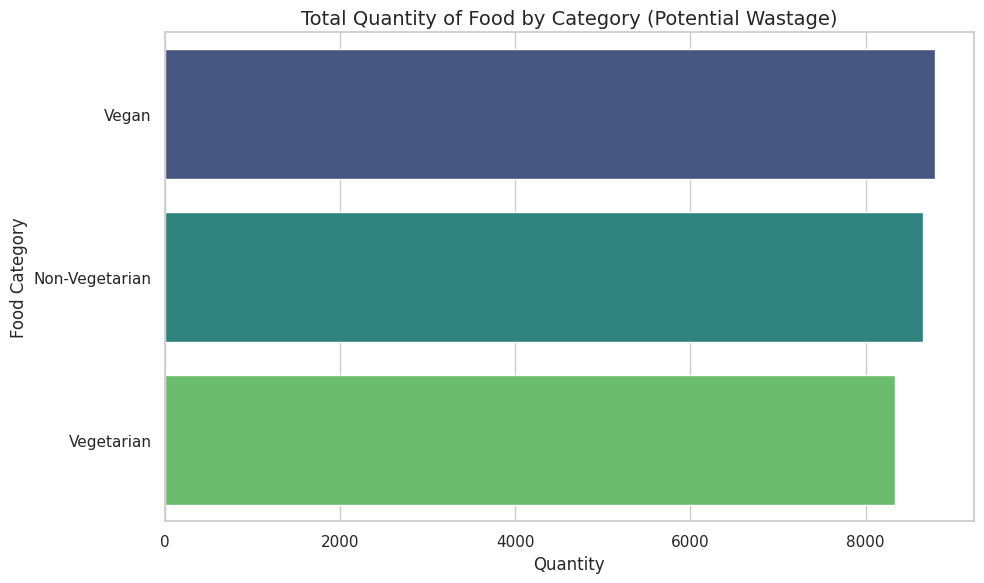

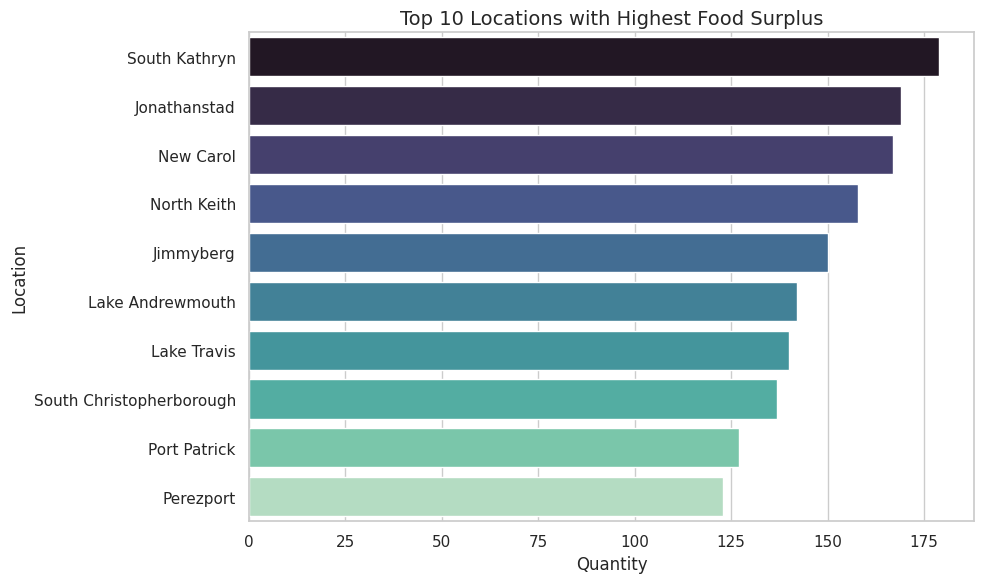

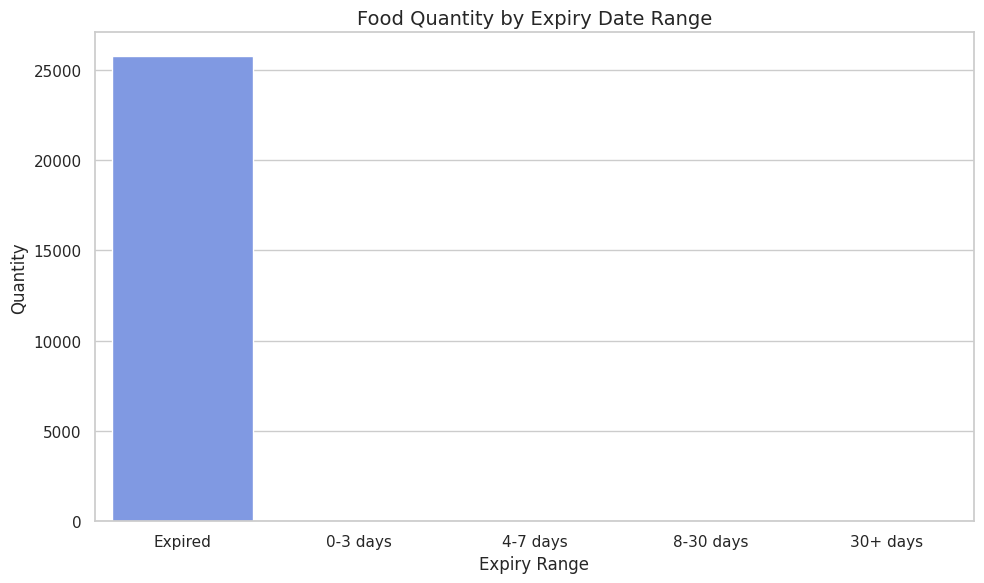

In [ ]:
# STEP 8 - Food Wastage Trends

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
from sqlalchemy import text
# Plot Styling
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
# Load Data from DB
with engine.connect() as conn:
    food_df = pd.read_sql(text("SELECT * FROM food_listings"), conn)
# Ensure proper datetime conversion
food_df["Expiry_Date"] = pd.to_datetime(food_df["Expiry_Date"], errors="coerce")
# TREND 1 - Total Quantity by Food Category
category_trend = food_df.groupby("Food_Type", as_index=False)["Quantity"].sum()
plt.figure()
sns.barplot(
    x="Quantity",
    y="Food_Type",
    hue="Food_Type",  # Added to avoid palette warning
    data=category_trend.sort_values("Quantity", ascending=False),
    palette="viridis",
    legend=False
)
plt.title("Total Quantity of Food by Category (Potential Wastage)", fontsize=14)
plt.xlabel("Quantity")
plt.ylabel("Food Category")
plt.tight_layout()
plt.show()
# TREND 2 - Top 10 Locations with Highest Surplus
location_trend = (
    food_df.groupby("Location", as_index=False)["Quantity"].sum()
    .sort_values("Quantity", ascending=False)
    .head(10)
)
plt.figure()
sns.barplot(
    x="Quantity",
    y="Location",
    hue="Location",
    data=location_trend,
    palette="mako",
    legend=False
)
plt.title("Top 10 Locations with Highest Food Surplus", fontsize=14)
plt.xlabel("Quantity")
plt.ylabel("Location")
plt.tight_layout()
plt.show()
# TREND 3 - Quantity by Expiry Date Range
today = datetime.today()
food_df["Days_To_Expire"] = (food_df["Expiry_Date"] - today).dt.days
def categorize_expiry(days):
    if pd.isna(days):
        return None
    elif days < 0:
        return "Expired"
    elif days <= 3:
        return "0-3 days"
    elif days <= 7:
        return "4-7 days"
    elif days <= 30:
        return "8-30 days"
    else:
        return "30+ days"
food_df["Expiry_Range"] = food_df["Days_To_Expire"].apply(categorize_expiry)
expiry_order = ["Expired", "0-3 days", "4-7 days", "8-30 days", "30+ days"]
expiry_trend = (
    food_df.groupby("Expiry_Range", as_index=False)["Quantity"].sum()
    .set_index("Expiry_Range")
    .reindex(expiry_order, fill_value=0)
    .reset_index()
)
plt.figure()
sns.barplot(
    x="Expiry_Range",
    y="Quantity",
    hue="Expiry_Range",
    data=expiry_trend,
    palette="coolwarm",
    legend=False
)
plt.title("Food Quantity by Expiry Date Range", fontsize=14)
plt.xlabel("Expiry Range")
plt.ylabel("Quantity")
plt.tight_layout()
plt.show()

In [ ]:
# STEP 9 - Generating Reports

import pandas as pd
from datetime import datetime
# Load data from DB
with engine.connect() as conn:
    food_df = pd.read_sql("SELECT * FROM food_listings", conn)
# Convert expiry date
food_df["Expiry_Date"] = pd.to_datetime(food_df["Expiry_Date"], errors="coerce")
# Calculate days to expire
today = datetime.today()
food_df["Days_To_Expire"] = (food_df["Expiry_Date"] - today).dt.days
# KEY METRICS
total_food_items = food_df["Quantity"].sum()
total_categories = food_df["Food_Type"].nunique()
expired_items = food_df[food_df["Days_To_Expire"] < 0]["Quantity"].sum()
soon_to_expire_items = food_df[
    (food_df["Days_To_Expire"] >= 0) & (food_df["Days_To_Expire"] <= 3)
]["Quantity"].sum()
print("\n===== 📦 FOOD DISTRIBUTION SUMMARY =====")
print(f"Total Food Quantity: {total_food_items}")
print(f"Total Food Categories: {total_categories}")
print(f"Expired Items: {expired_items}")
print(f"Soon-to-Expire Items (0-3 days): {soon_to_expire_items}\n")
# LOCATIONS WITH HIGHEST SURPLUS
location_focus = (
    food_df.groupby("Location")["Quantity"].sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)
location_focus.to_csv("Top Surplus Locations.csv", index=False)
print("✅ Saved: Top Surplus Locations.csv (focus distribution here first)")
# CATEGORY-LEVEL DISTRIBUTION
category_focus = (
    food_df.groupby("Food_Type")["Quantity"].sum()
    .sort_values(ascending=False)
    .reset_index()
)
category_focus.to_csv("Category Distribution.csv", index=False)
print("✅ Saved: Category Distribution.csv (helps balance food categories)")


===== 📦 FOOD DISTRIBUTION SUMMARY =====
Total Food Quantity: 25794
Total Food Categories: 3
Expired Items: 25794
Soon-to-Expire Items (0-3 days): 0

✅ Saved: Top Surplus Locations.csv (focus distribution here first)
✅ Saved: Category Distribution.csv (helps balance food categories)


In [ ]:
# STEP 10 - Streamlit Creation

app_code = """
import streamlit as st
import pandas as pd
import sqlite3

# =========================
# DATABASE CONNECTION
# =========================
DB_PATH = "Food Wastage.db"

def run_query(query, params=()):
    with sqlite3.connect(DB_PATH) as conn:
        return pd.read_sql(query, conn, params=params)

def execute_query(query, params=()):
    with sqlite3.connect(DB_PATH) as conn:
        cursor = conn.cursor()
        cursor.execute(query, params)
        conn.commit()

def get_table_columns(table_name):
    with sqlite3.connect(DB_PATH) as conn:
        cursor = conn.cursor()
        cursor.execute(f"PRAGMA table_info({table_name})")
        return [row[1] for row in cursor.fetchall()]

# =========================
# APP TITLE
# =========================
st.set_page_config(page_title="Food Wastage Insights Dashboard", layout="wide")
st.title("🍽 Food Wastage Insights Dashboard")

# =========================
# FILTERS
# =========================
st.sidebar.header("🔍 Filters")
location_filter = st.sidebar.text_input("Filter by City")
provider_filter = st.sidebar.text_input("Filter by Provider Name")
food_type_filter = st.sidebar.text_input("Filter by Food Type")
provider_type_filter = st.sidebar.text_input("Filter by Provider Type")

# Check provider table columns
provider_columns = get_table_columns("providers")

# =========================
# SQL QUERIES
# =========================
queries = {
    "Providers & Receivers by City": '''
        SELECT p.City,
               COUNT(DISTINCT p.Provider_ID) AS Providers,
               COUNT(DISTINCT r.Receiver_ID) AS Receivers
        FROM providers p
        LEFT JOIN receivers r ON p.City = r.City
        GROUP BY p.City;
    ''',
    "Top Food Provider Type": '''
        SELECT Provider_Type, SUM(Quantity) AS Total_Food
        FROM providers p
        JOIN food_listings f ON p.Provider_ID = f.Provider_ID
        GROUP BY Provider_Type
        ORDER BY Total_Food DESC;
    ''' if "Provider_Type" in provider_columns else None,
    "Provider Contact by City": '''
        SELECT Name, Contact, City
        FROM providers
        WHERE City LIKE ?;
    ''',
    "Top Receivers by Claims": '''
        SELECT r.Name, COUNT(c.Claim_ID) AS Total_Claims
        FROM receivers r
        JOIN claims c ON r.Receiver_ID = c.Receiver_ID
        GROUP BY r.Name
        ORDER BY Total_Claims DESC;
    ''',
    "Total Quantity Available": '''
        SELECT SUM(Quantity) AS Total_Available
        FROM food_listings;
    ''',
    "City with Most Listings": '''
        SELECT Location, COUNT(*) AS Listing_Count
        FROM food_listings
        GROUP BY Location
        ORDER BY Listing_Count DESC
        LIMIT 1;
    ''',
    "Most Common Food Types": '''
        SELECT Food_Type, COUNT(*) AS Count
        FROM food_listings
        GROUP BY Food_Type
        ORDER BY Count DESC;
    ''',
    "Claims per Food Item": '''
        SELECT f.Food_Type, COUNT(c.Claim_ID) AS Claims
        FROM claims c
        JOIN food_listings f ON c.Food_ID = f.Food_ID
        GROUP BY f.Food_Type;
    ''',
    "Provider with Most Successful Claims": '''
        SELECT p.Name, COUNT(c.Claim_ID) AS Successful_Claims
        FROM providers p
        JOIN food_listings f ON p.Provider_ID = f.Provider_ID
        JOIN claims c ON f.Food_ID = c.Food_ID
        WHERE c.Status = 'Completed'
        GROUP BY p.Name
        ORDER BY Successful_Claims DESC
        LIMIT 1;
    ''',
    "Claim Status Percentages": '''
        SELECT Status,
               ROUND((COUNT(*) * 100.0 / (SELECT COUNT(*) FROM claims)), 2) AS Percentage
        FROM claims
        GROUP BY Status;
    ''',
    "Avg Quantity Claimed per Receiver": '''
        SELECT r.Name, ROUND(AVG(f.Quantity), 2) AS Avg_Quantity
        FROM receivers r
        JOIN claims c ON r.Receiver_ID = c.Receiver_ID
        JOIN food_listings f ON c.Food_ID = f.Food_ID
        GROUP BY r.Name;
    ''',
    "Most Claimed Meal Type": '''
        SELECT Meal_Type, COUNT(*) AS Claims
        FROM food_listings f
        JOIN claims c ON f.Food_ID = c.Food_ID
        GROUP BY Meal_Type
        ORDER BY Claims DESC
        LIMIT 1;
    ''',
    "Total Quantity by Provider": '''
        SELECT p.Name, SUM(f.Quantity) AS Total_Donated
        FROM providers p
        JOIN food_listings f ON p.Provider_ID = f.Provider_ID
        GROUP BY p.Name;
    '''
}

# =========================
# DISPLAY RESULTS
# =========================
st.header("📊 SQL Insights")

for title, sql in queries.items():
    if sql:
        st.subheader(title)
        if "Provider Contact by City" in title:
            df = run_query(sql, (f"%{location_filter}%",))
        else:
            df = run_query(sql)
        st.dataframe(df)

# =========================
# PROVIDER CONTACT DETAILS
# =========================
st.header("📞 Contact Food Providers Directly")

contact_query = "SELECT Name, City, Contact" + (", Provider_Type" if "Provider_Type" in provider_columns else "") + " FROM providers WHERE 1=1"
params = []

if location_filter:
    contact_query += " AND City LIKE ?"
    params.append(f"%{location_filter}%")
if provider_type_filter and "Provider_Type" in provider_columns:
    contact_query += " AND Provider_Type LIKE ?"
    params.append(f"%{provider_type_filter}%")
if provider_filter:
    contact_query += " AND Name LIKE ?"
    params.append(f"%{provider_filter}%")

contact_df = run_query(contact_query, tuple(params))
st.dataframe(contact_df)

# =========================
# CRUD OPERATIONS
# =========================
st.header("🛠 Manage Records")

crud_action = st.selectbox("Select Action", ["Add Provider", "Update Provider", "Delete Provider"])

if crud_action == "Add Provider":
    name = st.text_input("Name")
    city = st.text_input("City")
    contact = st.text_input("Contact")
    provider_type = st.text_input("Provider Type") if "Provider_Type" in provider_columns else None
    if st.button("Add"):
        if "Provider_Type" in provider_columns:
            execute_query(
                "INSERT INTO providers (Name, City, Provider_Type, Contact) VALUES (?, ?, ?, ?)",
                (name, city, provider_type, contact)
            )
        else:
            execute_query(
                "INSERT INTO providers (Name, City, Contact) VALUES (?, ?, ?)",
                (name, city, contact)
            )
        st.success("Provider added successfully!")

elif crud_action == "Update Provider":
    provider_id = st.number_input("Provider ID", step=1)
    contact = st.text_input("New Contact")
    if st.button("Update"):
        execute_query(
            "UPDATE providers SET Contact = ? WHERE Provider_ID = ?",
            (contact, provider_id)
        )
        st.success("Provider updated successfully!")

elif crud_action == "Delete Provider":
    provider_id = st.number_input("Provider ID", step=1)
    if st.button("Delete"):
        execute_query("DELETE FROM providers WHERE Provider_ID = ?", (provider_id,))
        st.success("Provider deleted successfully!")
"""

with open("app.py", "w") as f:
    f.write(app_code)

In [ ]:
# STEP 11 - Streamlit Deployment

# Install necessary packages
!pip install -q streamlit pyngrok
# Import required libraries
import os
from pyngrok import ngrok, conf
import time
# CONFIGURE NGROK
NGROK_AUTH_TOKEN = "2z0Oqv0tD166fELGCHwV2gLZwq1_2G2zUQRSs6C27k9vdzxwq"
conf.get_default().auth_token = NGROK_AUTH_TOKEN
# LOGS DIRECTORY
os.makedirs("/content/logs", exist_ok=True)
# RUN STREAMLIT IN BACKGROUND
!streamlit run app.py --server.port 8501 --server.address 0.0.0.0 > /content/logs/app_log.txt 2>&1 &
# Give Streamlit time to boot
time.sleep(5)
# CONNECT NGROK TO STREAMLIT
public_url = ngrok.connect(8501)
print("🚀 Your Streamlit app is live at:", public_url)

🚀 Your Streamlit app is live at: NgrokTunnel: "https://cf187e43ab59.ngrok-free.app" -> "http://localhost:8501"
